In [46]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
%matplotlib inline

sns.set_theme()

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, we will build a SciKit Learn linear regression model to predict Yen futures ("settle") returns with *lagged* CAD/JPY exchange rate returns. 

In [47]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("./data/cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [48]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Data Preparation

### Returns

In [49]:
# Create a series using "Price" percentage returns, drop any nan's, and check the results
returns = cad_jpy_df['Price'].pct_change() * 100
cad_jpy_df['Return'] = returns
cad_jpy_df.tail()

,Price,Open,High,Low,Return
Date,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697
2020-06-01,79.27,78.21,79.36,78.04,1.251756
2020-06-02,80.40,79.26,80.56,79.15,1.425508
2020-06-03,80.70,80.40,80.82,79.96,0.373134
2020-06-04,80.71,80.80,80.89,80.51,0.012392


### Lagged Returns 

In [50]:
# Create a lagged return using the shift function
cad_jpy_df['Lagged Return'] = returns.shift()
cad_jpy_df.dropna(inplace=True)
cad_jpy_df.head()

,Price,Open,High,Low,Return,Lagged Return
Date,,,,,,
1990-01-04,123.46,123.41,123.46,123.41,-1.468476,-0.846720
1990-01-05,124.54,124.48,124.54,124.48,0.874777,-1.468476
1990-01-08,124.27,124.21,124.27,124.21,-0.216798,0.874777
1990-01-09,125.10,125.04,125.10,125.04,0.667901,-0.216798
1990-01-10,125.81,125.75,125.81,125.75,0.567546,0.667901


### Train Test Split

In [51]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = cad_jpy_df[:'2017']
test = cad_jpy_df['2018':]

In [52]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train['Lagged Return'].to_frame()
X_test = test['Lagged Return'].to_frame()
y_train = train['Return']
y_test = test['Return']

In [53]:
# Preview the X_train data
X_train.head()

,Lagged Return
Date,
1990-01-04,-0.846720
1990-01-05,-1.468476
1990-01-08,0.874777
1990-01-09,-0.216798
1990-01-10,0.667901


# Linear Regression Model

In [54]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

**Note:** We want to evaluate the model using data that it has never seen before, in this case: `X_test`.

In [55]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [56]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
results = y_test.to_frame()
results.columns = ['Return']
results['Predicted Return'] = predictions
results.head()

,Return,Predicted Return
Date,,
2018-01-01,0.245591,0.005434
2018-01-02,-0.055679,-0.007317
2018-01-03,0.011142,0.000340
2018-01-04,0.601604,-0.001358
2018-01-05,0.919158,-0.016366


array([<AxesSubplot:xlabel='Date', ylabel='Price'>,
       <AxesSubplot:xlabel='Date', ylabel='Price'>], dtype=object)

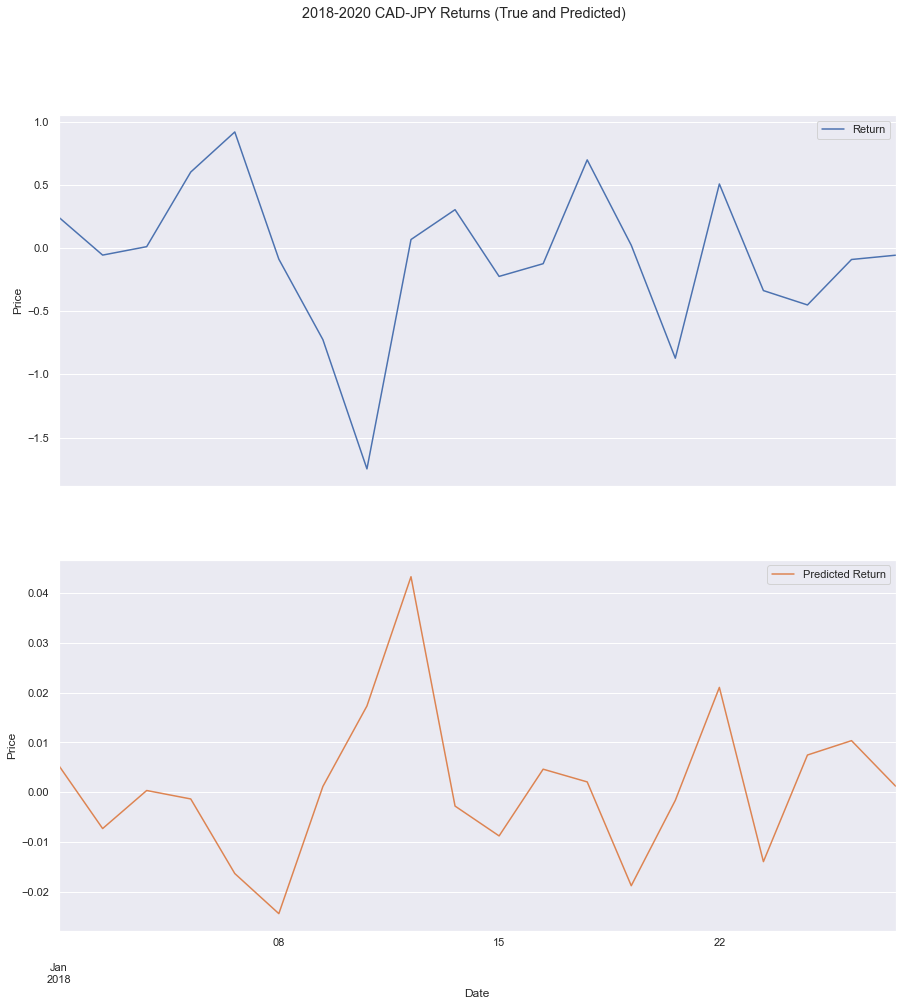

In [57]:
# Plot the first 20 predictions vs the true values
results[:20].plot(
    subplots=True, 
    figsize=(15, 15), 
    ylabel='Price',
    xlabel='Date',
    title="2018-2020 CAD-JPY Returns (True and Predicted)"
)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (`X_test` and `y_test`)

In [58]:
from sklearn.metrics import mean_squared_error

# Calculate the mean-squared error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    results['Return'],
    results['Predicted Return']
)

# Using the mean-squared error, calculate the root-mean-squared error (RMSE)
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.6445805658569028


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [59]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results['In-sample Predictions'] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results['Return'],
    in_sample_results['In-sample Predictions']
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.841994632894117


# Conclusions

A lower RMSE equates to a better prediction. On this principle, we can conclude that our model is more accurate on out-of-sample data rather than in-sample data. 